In [1]:
# Import all necessary libraries.

import numpy as np
import os
import cv2
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
import matplotlib.pyplot as plt

Image.MAX_IMAGE_PIXELS = None

2024-05-01 12:32:24.212420: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/alexwilson/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# ELF geometry calculation functions.

def get_aircraft_data():
    # Aircraft dictionary containing all necessary data points for further calculations.
    # For a new aircraft, the data values should be changed.
    aircraft = {'Vtd_m/s': 25.191, 'tr_s': 3, 'g_m/s2': 9.807, 'rho_kg/m3': 1.225,
            'wingArea_m2': 16.72, 'wingSpan_m': 11.02, 'mass_kg': 975, 'mu_R': 0.2, 
            'alpha_deg': 0, 'LDmax': 11}
    return aircraft

def get_environment_data():
    # Environment dictionary containing all necessary data points for further calculations.
    # For an alternative environment, the data values should be changed.
    environment = {'accelDueToGrav_m/s2': 9.807, 'densityOfAir_kg/m3': 1.225, 'rollingFrictionCoef': 0.2}
    return environment

def get_CL(m, g, rho, V, S):
    # Calculate the lift coefficient (Equation 4).
    return (m*g)/(0.5*rho*V**2*S)

def get_A(b, S):
    # Calculate the aspect ratio (Equation 9).
    A = b**2/S
    return A

def get_oswaldEff(b, S):
    # Calculate the Oswald's Efficiency Factor (Equation 10).
    A = get_A(b, S)
    e = 1.78*(1-0.045*A**0.68)-0.64
    return e

def get_K(b, S):
    # Calculate the K-value (Equation 8).
    A = get_A(b, S)
    e = get_oswaldEff(b, S)
    K = 1/(np.pi*A*e)
    return K

def get_CD0(LDmax, b, S):
    # Calculate the zero-lift drag coefficient (Equation 7).
    K = get_K(b, S)
    CD0 = 1/((2*LDmax)**2*K)
    return CD0

def get_length_safety_factor(image_prediction):
    # Determine safety factor for length of landing field.
    if image_prediction == 1:
        sf = 1
    else:
        sf = 1.15
    return sf

def get_width_safety_factor():
    # Determine safety factor for width of landing field.
    sf = 3
    return sf

def get_ground_roll(aircraft, environment):
    # Calculate the ground roll (Equation 19 without safety factor).
    Vtd = aircraft['Vtd_m/s']
    tr = aircraft['tr_s']
    LDmax = aircraft['LDmax']
    b = aircraft['wingSpan_m']
    S = aircraft['wingArea_m2']
    m = aircraft['mass_kg']

    g = environment['accelDueToGrav_m/s2']
    rho = environment['densityOfAir_kg/m3']
    mu = environment['rollingFrictionCoef']

    W = m*g

    CL = get_CL(m, g, rho, 
                Vtd, S)
    CD0 = get_CD0(LDmax, b, S)
    K = get_K(b, S)
    alpha = aircraft['alpha_deg']

    ground_roll = Vtd*tr+(1/(2*g*((rho*S)/(2*W))*(mu*CL-CD0-K*CL**2)))*np.log((-np.sin(alpha)-mu*np.cos(alpha))/(-np.sin(alpha)-mu*np.cos(alpha)+((rho*S)/(2*W))*(mu*CL-CD0-K*CL**2)*Vtd**2))
    return ground_roll

def get_field_dimensions(ground_roll, aircraft, lSF, wSF):
    # Determine the length and width of the landing field accounting for safety factors.
    le = ground_roll*lSF
    wi =  aircraft['wingSpan_m']*wSF
    Ar = le * wi
    print(f"Length of field: {le:.2f} m")
    print(f"Width of field: {wi:.2f} m")
    return le, wi, Ar

def get_field_dimensions_in_pixels(le, wi, Ar):
    # Convert the field dimensions from metres to pixels.
    g_res = 0.4425
    le_pixel = le/g_res
    wi_pixel = wi/g_res
    Ar_pixel = Ar/(g_res**2)
    print(f"Length of field: {le_pixel:.2f} pixels")
    print(f"Width of field: {wi_pixel:.2f} pixels")
    return le_pixel, wi_pixel, Ar_pixel

In [3]:
# Image processing functions.

def get_image(file_path):
    # Load image from file into a numpy array.
    img = cv2.imread(file_path)
    return img

def resize_image(file_path):
    # Resize image to 224x224 pixels.
    save_path = "rszd_img.jpg"
    img = Image.open(file_path)
    img = img.resize((224, 224))
    img.save(save_path)
    img = tf.io.read_file(save_path)
    img_tp = cv2.imread(save_path)
    return tf.image.decode_jpeg(img, channels=3), img_tp


In [4]:
# Model instantiation and prediction function. It is important that the model
# is instantiated before running the main program to minimise the runtime.

def build_model():
    # Construct EfficientNetV2-B0 model and load weights.
    m = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(224, 224)+(3,)),
        hub.KerasLayer("https://www.kaggle.com/models/google/efficientnet-v2/TensorFlow2/imagenet1k-b0-feature-vector/2", trainable=False),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(3, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
    ])
    m.build((None,)+(224, 224)+(3,))
    m.load_weights("/Users/alexwilson/Documents/University/ThirdYear/IndividualProject/coding/models/efficientNetSGD.weights.h5")
    return m

model = build_model()

def get_image_prediction(img, m):
    # Return decoded prediction from model.
    p = np.argmax(m.predict(img), axis=1)
    return p

In [5]:
# Suitability verification functions.

def are_all_points_inside_polygon(points, polygon):
    # Check if all points are inside the polygon
    return all(cv2.pointPolygonTest(polygon, (int(point[0]), int(point[1])), False) >= 0 for point in points)

def calculate_ELF_along_line(p1, p2, rect_length, rect_width):
    # Calculate the ELF geometry along the longest line.

    # Convert points to numpy arrays for easier calculations
    p1 = np.array(p1, dtype=np.float32)
    p2 = np.array(p2, dtype=np.float32)
    
    # Calculate the midpoint of the longest line
    midpoint = (p1 + p2) / 2
    
    # Calculate the direction vector from p1 to p2 and normalize it
    dir_vector = p2 - p1
    dir_vector_norm = dir_vector / np.linalg.norm(dir_vector)
    
    # Calculate points along the longest line at specified rectangle length
    half_length = rect_length / 2
    point_on_line_a = midpoint - dir_vector_norm * half_length
    point_on_line_b = midpoint + dir_vector_norm * half_length
    
    # Calculate the perpendicular direction vector
    perp_vector = np.array([-dir_vector_norm[1], dir_vector_norm[0]])
    
    # Calculate the width offset from the line to get rectangle corners
    half_width = rect_width / 2
    corner1 = point_on_line_a + perp_vector * half_width
    corner2 = point_on_line_a - perp_vector * half_width
    corner3 = point_on_line_b - perp_vector * half_width
    corner4 = point_on_line_b + perp_vector * half_width
    
    return np.array([corner1, corner2, corner3, corner4], dtype=np.int32)

def bounding_polygons(img):
    # Construct a mask based upon HSV pixel values to create binary
    # landable or unlandable zones. Subsequently build bounding polygons
    # based upon the largest contours found in the mask.

    # Define the lower and upper bounds of the desirable range in HSV space
    lower = np.array([5, 20, 70])
    upper = np.array([50, 115, 160])

    # Convert the image to HSV space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Create a mask for the desirable color
    mask = cv2.inRange(hsv, lower, upper)

    # Apply morphological operations to remove noise and smooth the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the bounding polygon for the largest and second largest contours in the green mask
    if len(contours) > 0:
        contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)
        largest_contour = contours_sorted[0]
        second_largest_contour = contours_sorted[1] if len(contours_sorted) > 1 else None

        # Draw the polygon on the image for the largest contour
        epsilon = 0.02 * cv2.arcLength(largest_contour, True)
        approx_largest = cv2.approxPolyDP(largest_contour, epsilon, True)
        cv2.drawContours(img, [approx_largest], -1, (0, 255, 0), 2)

        # Draw the polygon on the image for the second largest contour
        if second_largest_contour is not None:
            epsilon = 0.02 * cv2.arcLength(second_largest_contour, True)
            approx_second = cv2.approxPolyDP(second_largest_contour, epsilon, True)
            cv2.drawContours(img, [approx_second], -1, (0, 255, 0), 2)
        else:
            approx_second = np.array([[]])
    else:
        approx_largest = np.array([[]])
        approx_second = np.array([[]])
    return approx_largest, approx_second

def feasibility_check(img, approx_largest, approx_second, le_pixel, wi_pixel):
    # Check the ELF geometry fits inside the bounding polygons.

    # Find the longest line in the bounding polygon for the largest contour
    line_length = 0
    for i in range(len(approx_largest)):
        for j in range(i, len(approx_largest)):
            dist = np.linalg.norm(approx_largest[i][0] - approx_largest[j][0])
            if dist > line_length:
                line_length = dist
                line_points = (approx_largest[i][0], approx_largest[j][0])

    # Draw the longest line on the image for the largest contour
    cv2.line(img, line_points[0], line_points[1], (0, 0, 255), 2)

    # Find the longest line in the bounding polygon for the second largest contour
    line_length_second = 0
    for i in range(len(approx_second)):
        for j in range(i, len(approx_second)):
            dist = np.linalg.norm(approx_second[i][0] - approx_second[j][0])
            if dist > line_length_second:
                line_length_second = dist
                line_points_second = (approx_second[i][0], approx_second[j][0])

    # Draw the longest line on the image for the second largest contour
    if line_length_second > 0:
        cv2.line(img, line_points_second[0], line_points_second[1], (0, 0, 255), 2)

    ELF_length = le_pixel  # Length along the longest line
    ELF_width = wi_pixel   # Width perpendicular to the longest line

    for polygon in [approx_largest, approx_second]:
        if polygon is not None:
            # Calculate the longest line, its midpoint, and then the rectangle
            # Assuming you have line_points and line_length as before
            rect_corners = calculate_ELF_along_line(line_points[0], line_points[1], ELF_length, ELF_width)
        
            # Ensure the rectangle is fully within the polygon
            if are_all_points_inside_polygon(rect_corners, polygon):
                # The rectangle is within the polygon, draw it
                cv2.polylines(img, [rect_corners], isClosed=True, color=(255, 255, 0), thickness=2)
                print("**POSSIBLE ELF** ... Successful fit within the landable region.")
            else:
                print("Unable to fit within the landable region.")
    return img

In [6]:
aircraft_data = get_aircraft_data()
environment_data = get_environment_data()
ground_roll = get_ground_roll(aircraft_data, environment_data)
print(f"Ground roll (m): {ground_roll:.2f}")

Ground roll (m): 295.78


In [7]:
# Main Program for a single image

# Get image
file_path = "/Volumes/ExternalSSD/individualProject/rawImages/fmow_rgb_train_final/crop_field/crop_field_0/crop_field_0_9_rgb.jpg"
img = get_image(file_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Pre-process image
rszd_img, rszd_img_tp = resize_image(file_path)
rszd_img_rgb = cv2.cvtColor(rszd_img_tp, cv2.COLOR_BGR2RGB)

numpy_img = rszd_img.numpy()
numpy_img_sized = numpy_img[np.newaxis, ...]

# Get image prediction
image_prediction = get_image_prediction(numpy_img_sized, model)

if image_prediction == 2:
    print('**Image is classified as UNLANDABLE**')
else:
    # Get safety factors
    length_safety_factor = get_length_safety_factor(image_prediction)
    width_safety_factor = get_width_safety_factor()

    # Calculate ELF geometry
    le, wi, Ar = get_field_dimensions(ground_roll, aircraft_data, length_safety_factor, width_safety_factor)
    
    # Get ELF gemometry in pixels
    le_pixel, wi_pixel, Ar_pixel = get_field_dimensions_in_pixels(le, wi, Ar)

    # Segment image
    largest_poly, second_poly = bounding_polygons(img)
    # Feasibility check image
    fnl_img = feasibility_check(img, largest_poly, second_poly, le_pixel, wi_pixel)
    fnl_img_rgb = cv2.cvtColor(fnl_img, cv2.COLOR_BGR2RGB)
    

[ WARN:0@92.421] global loadsave.cpp:248 findDecoder imread_('/Volumes/ExternalSSD/individualProject/rawImages/fmow_rgb_train_final/crop_field/crop_field_0/crop_field_0_9_rgb.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


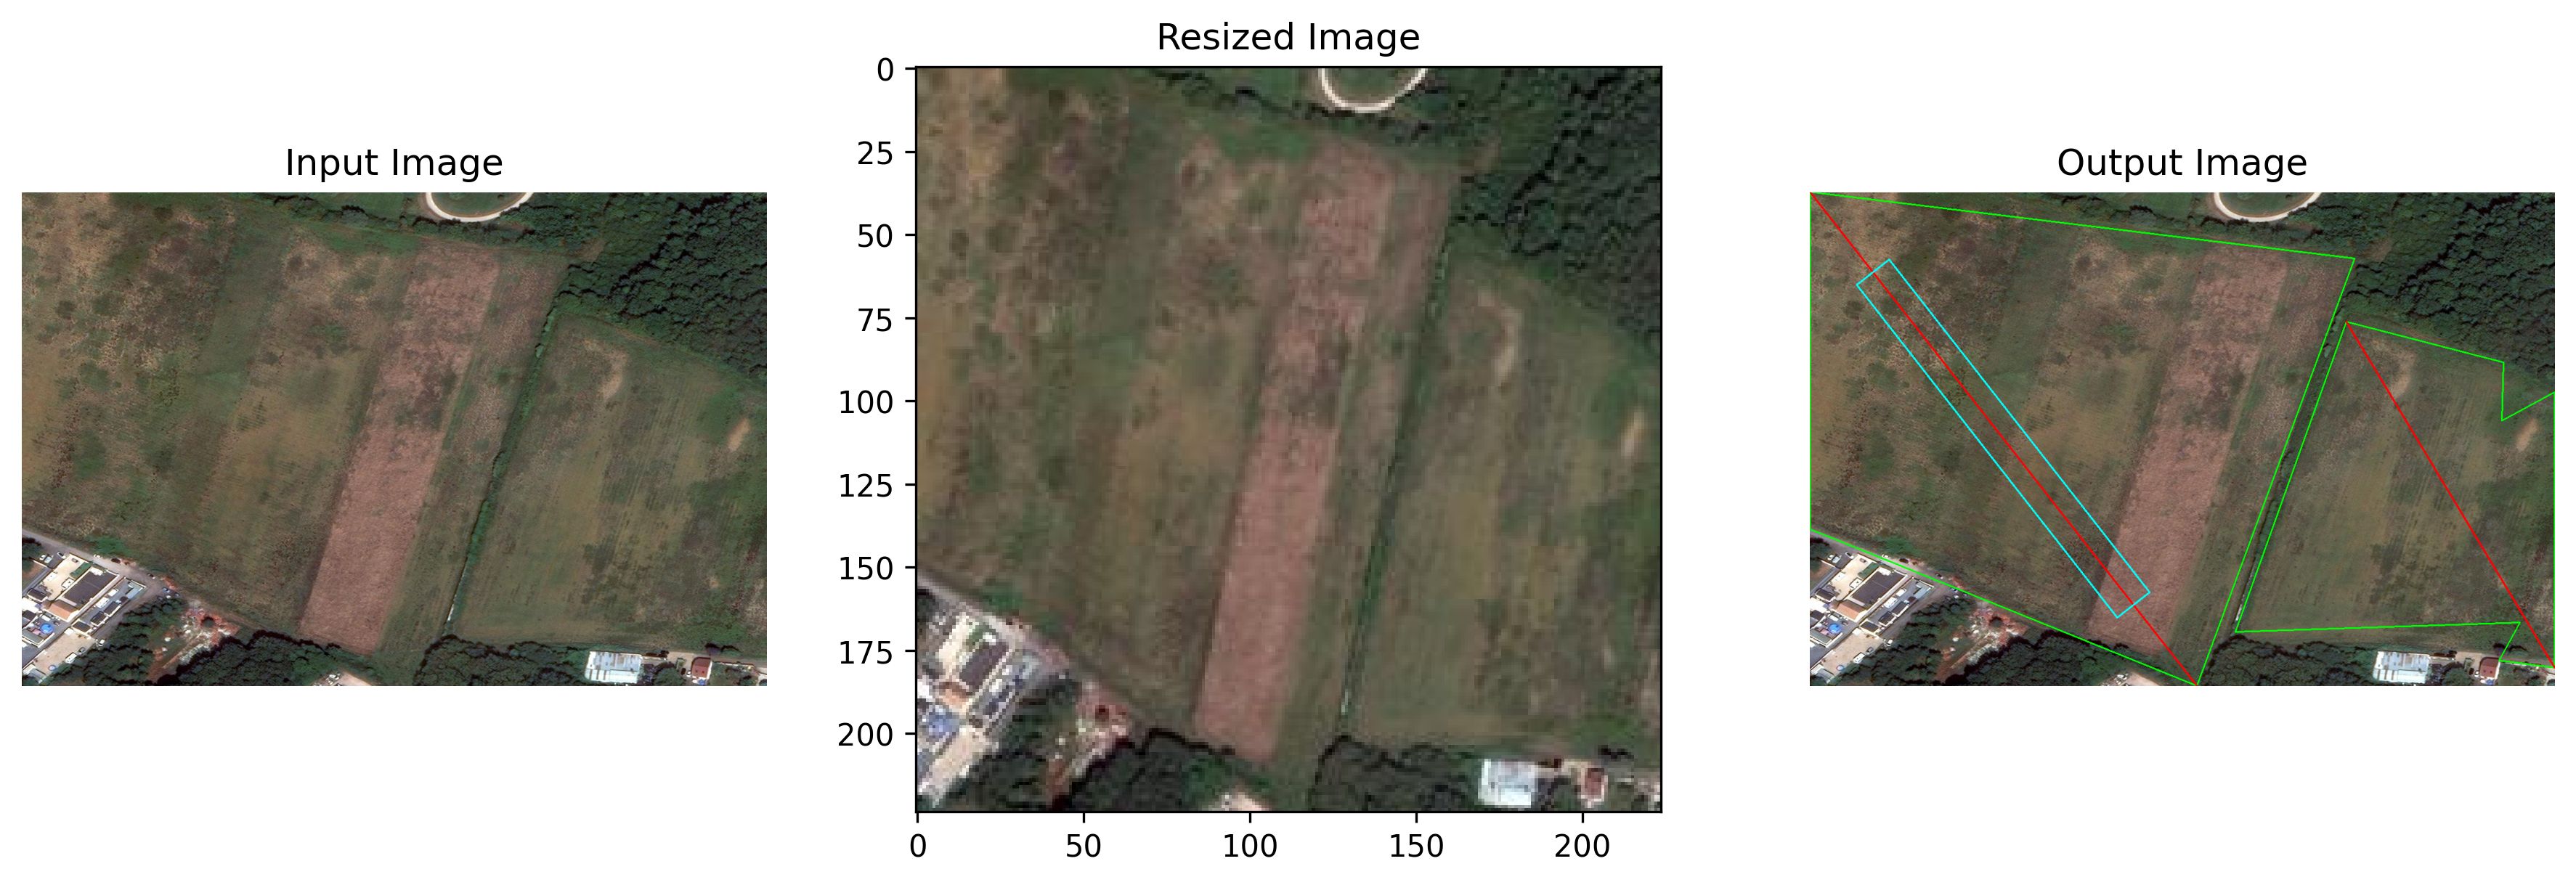

In [12]:
# Plot relevant images during the process.

# Set up the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=300)  # 1 row, 3 columns

# Plot each image
axs[0].imshow(img_rgb)
axs[0].set_title('Input Image')
axs[0].axis('off')

axs[1].imshow(rszd_img_rgb)
axs[1].set_title('Resized Image')
axs[1].axis()  

axs[2].imshow(fnl_img_rgb)
axs[2].set_title('Output Image')
axs[2].axis('off')  

# Show the plot
plt.show()

In [10]:
# Main program for all images in a given directory.

# Define the directory path that contains the images
directory_path = "/Users/alexwilson/Documents/University/ThirdYear/IndividualProject/images/testImages"

# Iterate over each file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith(".jpg"):  # Assumes files are JPEG images
        file_path = os.path.join(directory_path, filename)
        
        # Load and process the image
        img = get_image(file_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Pre-process image
        rszd_img, rszd_img_tp = resize_image(file_path)
        rszd_img_rgb = cv2.cvtColor(rszd_img_tp, cv2.COLOR_BGR2RGB)

        numpy_img = rszd_img.numpy()
        numpy_img_sized = numpy_img[np.newaxis, ...]

        # Get image prediction
        image_prediction = get_image_prediction(numpy_img_sized, model)

        if image_prediction == 2:
            print(f'**Image {filename} is classified as UNLANDABLE**')
        else:
            # Get safety factors
            length_safety_factor = get_length_safety_factor(image_prediction)
            width_safety_factor = get_width_safety_factor()

            # Calculate ELF geometry
            le, wi, Ar = get_field_dimensions(ground_roll, aircraft_data, length_safety_factor, width_safety_factor)
            
            # Get ELF geometry in pixels
            le_pixel, wi_pixel, Ar_pixel = get_field_dimensions_in_pixels(le, wi, Ar)

            # Segment image
            largest_poly, second_poly = bounding_polygons(img)
            print(largest_poly.size)
            if largest_poly.size == 0 or second_poly.size == 0:
                print('**Unreliable result due to colour error**')
            else:
                # Feasibility check image
                fnl_img = feasibility_check(img, largest_poly, second_poly, le_pixel, wi_pixel)
                fnl_img_rgb = cv2.cvtColor(fnl_img, cv2.COLOR_BGR2RGB)

        print(f'Processed {filename} successfully')

1/1 [==============================] - 0s 88ms/step
Length of field: 295.78 m
Width of field: 33.06 m
Length of field: 668.43 pixels
Width of field: 74.71 pixels
16
Unable to fit within the landable region.
Unable to fit within the landable region.
Processed 0000351_7_rgb.jpg successfully
1/1 [==============================] - 0s 56ms/step
Length of field: 295.78 m
Width of field: 33.06 m
Length of field: 668.43 pixels
Width of field: 74.71 pixels
22
Unable to fit within the landable region.
Unable to fit within the landable region.
Processed 0000253_6_rgb.jpg successfully
1/1 [==============================] - 0s 67ms/step
**Image 0000057_4_rgb.jpg is classified as UNLANDABLE**
Processed 0000057_4_rgb.jpg successfully
1/1 [==============================] - 0s 55ms/step
**Image 0000363_5_rgb.jpg is classified as UNLANDABLE**
Processed 0000363_5_rgb.jpg successfully
1/1 [==============================] - 0s 57ms/step
Length of field: 295.78 m
Width of field: 33.06 m
Length of field: 668